In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, QuantileRegressor
from xgboost import XGBRegressor

# =========================
# CONFIG
# =========================
CSV_PATH     = "SX5E.csv"
YEAR_COL     = "Year"
TARGET_COL   = "Actual"
FUTURES_COL  = "Futures"
TEST_YEARS   = [2023, 2024]
TRAIN_END    = 2022
RANDOM_STATE = 42

# Base feature list (we will explicitly DROP Futures when training the residual model)
FEATURE_COLS = [
    "Futures",            # present in data, but EXCLUDED from residual features
    "DPS_lag1", "DPS_growth",
    "EPS_lag1", "EPS_growth",
    "Revenue_growth",
    "FCFPS_lag1"
]

# =========================
# HELPERS
# =========================
def coerce_numeric(col: pd.Series) -> pd.Series:
    s = (col.astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("—", "", regex=False)
            .str.strip())
    s = s.where(s != "-", np.nan)  # lone "-" => missing
    return pd.to_numeric(s, errors="coerce")

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if not m.any():
        return np.nan
    denom = (np.abs(y_true[m]) + np.abs(y_pred[m])) / 2.0
    denom = np.where(denom == 0, 1.0, denom)
    return 100.0 * np.mean(np.abs(y_true[m] - y_pred[m]) / denom)

def safe_metrics(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if not m.any():
        return {"MAE": np.nan, "R2": np.nan, "SMAPE_%": np.nan}
    return {
        "MAE": round(mean_absolute_error(y_true[m], y_pred[m]), 6),
        "R2":  round(r2_score(y_true[m], y_pred[m]), 6),
        "SMAPE_%": round(smape(y_true[m], y_pred[m]), 6),
    }

# =========================
# LOAD & CLEAN
# =========================
df = pd.read_csv(CSV_PATH)

# drop 2020 entirely (COVID anomalies)
df = df[df[YEAR_COL] != 2020].copy()

# coerce numeric for target + features we expect might exist
cols_to_numeric = [TARGET_COL] + [c for c in FEATURE_COLS if c in df.columns]
for c in cols_to_numeric:
    df[c] = coerce_numeric(df[c]) if c in df.columns else np.nan

# ensure only existing feature columns are used;
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]

# For residual training, we will EXCLUDE Futures
RESID_FEATURE_COLS = [c for c in FEATURE_COLS if c != FUTURES_COL]

# =========================
# SPLIT
# =========================
train_mask = df[YEAR_COL] <= TRAIN_END
test_mask  = df[YEAR_COL].isin(TEST_YEARS)

X_train_all = df.loc[train_mask, FEATURE_COLS].copy()
y_train     = df.loc[train_mask, TARGET_COL].astype(float).copy()

X_test_all  = df.loc[test_mask,  FEATURE_COLS].copy()
y_test      = df.loc[test_mask,  TARGET_COL].astype(float).copy()

# =========================
# AUDIT / DROP INVALID TARGETS (TRAIN/TEST)
# =========================
cap = 1e12
mask_ytrain_ok = np.isfinite(y_train.values) & (np.abs(y_train.values) < cap)
if (~mask_ytrain_ok).sum():
    print("Dropping train rows with invalid target (NaN/Inf/too large):")
    print(df.loc[train_mask, [YEAR_COL, TARGET_COL]].loc[~mask_ytrain_ok])

X_train_all = X_train_all.loc[mask_ytrain_ok]
y_train     = y_train.loc[mask_ytrain_ok]

mask_ytest_ok = np.isfinite(y_test.values) & (np.abs(y_test.values) < cap)
if (~mask_ytest_ok).sum():
    print("Dropping test rows with invalid target (NaN/Inf/too large):")
    print(df.loc[test_mask, [YEAR_COL, TARGET_COL]].loc[~mask_ytest_ok])

X_test_all = X_test_all.loc[mask_ytest_ok]
y_test     = y_test.loc[mask_ytest_ok]

# ensure numeric dtype for features (NaNs allowed)
X_train_all = X_train_all.apply(pd.to_numeric, errors="coerce")
X_test_all  = X_test_all.apply(pd.to_numeric, errors="coerce")

# =========================
# BASELINE: pure Futures (on test rows where Futures exists)
# =========================
fut_test = X_test_all[FUTURES_COL] if FUTURES_COL in X_test_all.columns else pd.Series(index=X_test_all.index, dtype=float)
baseline_mask = fut_test.notna()
y_test_base   = y_test.loc[baseline_mask]
futures_base  = fut_test.loc[baseline_mask]
baseline_metrics = safe_metrics(y_test_base.values, futures_base.values)

# =========================
# RESIDUAL MODEL: XGBoost on (y - F), with FEATURES EXCLUDING Futures
# =========================
# Build a unified, sorted TRAIN dataframe aligned to cleaned indices
train_years = df.loc[train_mask, [YEAR_COL]].loc[X_train_all.index]
train_df = (
    X_train_all.join(y_train.rename("y")).join(train_years)
    .sort_values([YEAR_COL])
)

# Keep only rows with Futures available for the residual definition
has_fut_tr = train_df[FUTURES_COL].notna()
train_df_f = train_df.loc[has_fut_tr].copy()

# Residual target: y - Futures
resid_tr = (train_df_f["y"] - train_df_f[FUTURES_COL]).astype(float)

# Residual features: EXCLUDE Futures
Xtr_resid = train_df_f[RESID_FEATURE_COLS].copy()

# Time-series CV to get OOF residual predictions for combination step
tscv = TimeSeriesSplit(n_splits=3)
oof_resid_pred = pd.Series(index=train_df_f.index, dtype=float)

for tr_idx, va_idx in tscv.split(train_df_f):
    tr_ids = train_df_f.index[tr_idx]
    va_ids = train_df_f.index[va_idx]

    X_tr_fold = Xtr_resid.loc[tr_ids, :]
    y_tr_fold = resid_tr.loc[tr_ids]

    res_model_cv = XGBRegressor(
        n_estimators=500, max_depth=3, learning_rate=0.02,
        subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE
    )
    res_model_cv.fit(X_tr_fold, y_tr_fold)
    oof_resid_pred.loc[va_ids] = res_model_cv.predict(Xtr_resid.loc[va_ids, :])

# Fit combination coefficients (train-only)
valid_oof   = oof_resid_pred.notna()
y_for_ab    = train_df_f.loc[valid_oof, "y"].to_numpy()
fut_for_ab  = train_df_f.loc[valid_oof, FUTURES_COL].to_numpy()
res_for_ab  = oof_resid_pred.loc[valid_oof].to_numpy()
X_combo_tr  = np.column_stack([fut_for_ab, res_for_ab])

ols = LinearRegression(fit_intercept=False)
ols.fit(X_combo_tr, y_for_ab)
a_ls, b_ls = ols.coef_

try:
    qreg = QuantileRegressor(quantile=0.5, alpha=1e-4, fit_intercept=False, solver="highs")
    qreg.fit(X_combo_tr, y_for_ab)
    a_mae, b_mae = qreg.coef_
except Exception:
    a_mae, b_mae = a_ls, b_ls  # fallback

print(f"Train-learned coefficients (y ~ a*F + b*res_hat):\n  OLS: a={a_ls:.4f}, b={b_ls:.4f}\n  QR : a={a_mae:.4f}, b={b_mae:.4f}")

# Choose which coefficients to use on test
# For a purist decomposition, you can set: a_opt, b_opt = 1.0, 1.0
a_opt, b_opt = a_mae, b_mae

# Refit residual model on ALL train rows with Futures (using residual target y-F)
res_model = XGBRegressor(
    n_estimators=500, max_depth=3, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE
)
res_model.fit(Xtr_resid, resid_tr)

# =========================
# TEST PREDICTIONS
# =========================
# 1) Hybrid residual forecast on the subset where Futures exists
X_test_h   = X_test_all.loc[baseline_mask, RESID_FEATURE_COLS]  # EXCLUDE Futures
y_test_h   = y_test.loc[baseline_mask]
fut_te     = futures_base.to_numpy()
res_te_hat = res_model.predict(X_test_h)

hybrid_preds = a_opt * fut_te + b_opt * res_te_hat
hybrid_metrics = safe_metrics(y_test_h.values, hybrid_preds)

# 2) "Pure XGB" line here will represent the residual learner composed back to y:
#    yhat_xgb = F + res_hat  (set a=1,b=1)
xgb_pure_preds = futures_base.to_numpy() + res_te_hat
xgb_pure_metrics = safe_metrics(y_test_h.values, xgb_pure_preds)

# =========================
# OUTPUT TABLE
# =========================
out = pd.DataFrame({
    "Year": df.loc[X_test_all.index, YEAR_COL].values,
    "Actual": y_test.values,
    "Futures": fut_test.values,
    # Fill only where we had Futures (consistent with above)
    "XGB_Pred": np.nan,
    "Hybrid_Pred": np.nan
}, index=X_test_all.index)

out.loc[baseline_mask, "XGB_Pred"]    = xgb_pure_preds
out.loc[baseline_mask, "Hybrid_Pred"] = hybrid_preds
out = out.sort_values("Year")

out_path = "preds.csv"
out.to_csv(out_path, index=False)

print("\n=== Test metrics (2023–2024; evaluated where Futures exists) ===")
print("Futures baseline:", baseline_metrics)
print("XGB (y-F, then F+res):", xgb_pure_metrics)
print("Hybrid (learned a,b):", hybrid_metrics)
print(f"Saved predictions to: {out_path}")
print(out)

Dropping train rows with invalid target (NaN/Inf/too large):
     Year  Actual
357  2019     NaN
358  2018     NaN
359  2017     NaN
360  2016     NaN
361  2015     NaN
362  2014     NaN
372  2015     NaN
373  2014     NaN
Train-learned coefficients (y ~ a*F + b*res_hat):
  OLS: a=1.0915, b=-0.1937
  QR : a=1.0338, b=0.0538

=== Test metrics (2023–2024; evaluated where Futures exists) ===
Futures baseline: {'MAE': 41.673953, 'R2': 0.902079, 'SMAPE_%': np.float64(15.059001)}
XGB (y-F, then F+res): {'MAE': 49.55659, 'R2': 0.930212, 'SMAPE_%': np.float64(22.466454)}
Hybrid (learned a,b): {'MAE': 38.327561, 'R2': 0.915367, 'SMAPE_%': np.float64(13.896628)}
Saved predictions to: preds.csv
     Year   Actual  Futures    XGB_Pred  Hybrid_Pred
529  2023   190.00      NaN         NaN          NaN
441  2023   205.00    200.0  206.863852   207.131758
353  2023     7.00      5.0   12.916017     5.595217
177  2023   185.00    188.7  206.989415   196.064790
430  2023    14.05     11.3   18.077943   

In [39]:
arima = pd.read_csv("results/arima_rolling_by_ticker.csv")
arima

,Ticker,Year,Actual,Forecast,Error,Absolute_Error,APE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,ABI BB,2016,360.0,299.674571,-6.032543e+01,6.032543e+01,1.675706e-01,NaN,NaN,178.8071,2024.0
1,ABI BB,2017,360.0,360.000000,-1.710000e-13,1.710000e-13,4.740000e-16,NaN,NaN,172.3005,2023.0
2,ABI BB,2018,280.0,360.000000,8.000000e+01,8.000000e+01,2.857143e-01,NaN,NaN,132.7815,2022.0
3,ABI BB,2019,180.0,316.256934,1.362569e+02,1.362569e+02,7.569830e-01,NaN,NaN,94.5524,2021.0
4,ABI BB,2020,50.0,223.573751,1.735738e+02,1.735738e+02,3.471475e+00,NaN,NaN,82.8380,2020.0
...,...,...,...,...,...,...,...,...,...,...,...
423,WKL NA,2021,143.0,107.988648,-3.501135e+01,3.501135e+01,2.448346e-01,NaN,NaN,NaN,NaN
424,WKL NA,2022,166.0,143.583090,-2.241691e+01,2.241691e+01,1.350416e-01,NaN,NaN,NaN,NaN
425,WKL NA,2023,190.0,169.485842,-2.051416e+01,2.051416e+01,1.079693e-01,NaN,NaN,NaN,NaN
426,WKL NA,2024,219.0,196.758435,-2.224157e+01,2.224157e+01,1.015597e-01,NaN,NaN,NaN,NaN


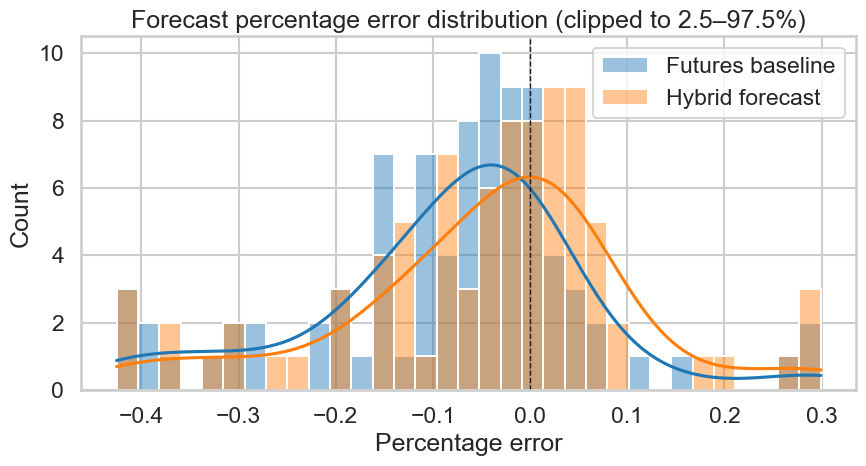

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Copy and compute again just in case
df = out.dropna().copy()
df["Futures % Error"] = df["Futures"]/df["Actual"] - 1
df["Hybrid % Error"]  = df["Hybrid_Pred"]/df["Actual"] - 1

# Winsorize to the 2.5th–97.5th percentile for plotting
lo, hi = np.percentile(df[["Futures % Error", "Hybrid % Error"]].values.flatten(), [2.5, 97.5])
df_plot = df.copy()
df_plot["Futures % Error"] = df["Futures % Error"].clip(lo, hi)
df_plot["Hybrid % Error"]  = df["Hybrid % Error"].clip(lo, hi)

# Plot
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(9,5))

sns.histplot(df_plot["Futures % Error"], bins=33, kde=True, color="#1f77b4",
             alpha=0.45, label="Futures baseline")
sns.histplot(df_plot["Hybrid % Error"], bins=33, kde=True, color="#ff7f0e",
             alpha=0.45, label="Hybrid forecast")

plt.axvline(0, color="k", lw=1, ls="--")
plt.xlabel("Percentage error")
plt.ylabel("Count")
plt.title("Forecast percentage error distribution (clipped to 2.5–97.5%)")
plt.legend()
plt.tight_layout()
plt.show()